In [1]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, ConvLSTM2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from ultralytics import YOLO
from constants import *
from util import extract_results

In [2]:
# Acceptable values: 1 (manual), 2 (hybrid), 3 (bounding box only)
MODEL_VERSION = 1

NUM_VIDEOS = 45
SEQUENCE_LENGTH = 10

### Preprocess Data 

In [3]:
label_map = {label:num for num, label in enumerate(ACTIONS)}

In [4]:
label_map

{'good': 0,
 'weaving': 1,
 'red_light': 2,
 'cross_yellow': 3,
 'off_road': 4,
 'collision': 5}

### Training with manual annotations

In [5]:
def extract_manual(keypoints, image_path):
    keypoints_norm = []
    pixels_around_box = []
    img = cv2.imread(image_path)

    xtl,ytl,w,h = keypoints[1], keypoints[2], keypoints[3], keypoints[4]
    w = int(w * IMAGE_WIDTH)
    h = int(h * IMAGE_HEIGHT)
    xtl = int((xtl * IMAGE_WIDTH) - (w/2))
    ytl = int((ytl * IMAGE_HEIGHT) - (h/2))
    xbr = xtl + w 
    ybr = ytl + h

    car_center = (int((xtl + xbr)/2), int((ytl + ybr)/2))
    keypoints_norm.append(car_center[0]/IMAGE_WIDTH)
    keypoints_norm.append(car_center[1]/IMAGE_HEIGHT)
    #keypoints_norm.append(xtl/IMAGE_WIDTH)
    #keypoints_norm.append(ytl/IMAGE_HEIGHT)
    #keypoints_norm.append(xbr/IMAGE_WIDTH)
    #keypoints_norm.append(ybr/IMAGE_HEIGHT)
    cv2.rectangle(img, (xtl, ytl), (xbr, ybr), [255,0,0], 1)
    cv2.circle(img, (car_center[0], car_center[1]), 1, [255,0,0], -1)
                
    keypoints_points = keypoints[5:]
    for i in range(0, len(keypoints_points), 3):
        k = i + 2
        if (k > len(keypoints_points)):
            break
        if keypoints_points[k] == 0:
            keypoints_norm.append(0)
            keypoints_norm.append(0)
        else:
            keypoints_norm.append(keypoints_points[i])
            keypoints_norm.append(keypoints_points[i+1])
            cv2.circle(img, (int(keypoints_points[i]*IMAGE_WIDTH),int(keypoints_points[i+1]*IMAGE_HEIGHT)), 1, [0,255,0], -1)

    if xtl != 0 and ytl != 0:
        pixels_top_left = img[ytl-PIXELS_HEIGHT+40: ytl+40,  xtl-PIXELS_WIDTH:xtl]
        pixels_bottom_left = img[ybr: ybr+PIXELS_HEIGHT, xtl-PIXELS_WIDTH:xtl]
        pixels_top_right = img[ytl-PIXELS_HEIGHT+40: ytl+40, xbr:xbr+PIXELS_WIDTH]
        pixels_bottom_right = img[ybr: ybr+PIXELS_HEIGHT, xbr:xbr+PIXELS_WIDTH]

        pixels_top_left = pixels_top_left.flatten()
        pixels_bottom_left = pixels_bottom_left.flatten()
        pixels_top_right = pixels_top_right.flatten()
        pixels_bottom_right = pixels_bottom_right.flatten()

        pad_width = PIXELS_ARRAY_SIZE - len(pixels_top_left)
        pixels_top_left = np.pad(pixels_top_left, (0, pad_width), mode='constant', constant_values=0)
        pad_width = PIXELS_ARRAY_SIZE - len(pixels_bottom_left)
        pixels_bottom_left = np.pad(pixels_bottom_left, (0, pad_width), mode='constant', constant_values=0)
        pad_width = PIXELS_ARRAY_SIZE - len(pixels_top_right)
        pixels_top_right = np.pad(pixels_top_right, (0, pad_width), mode='constant', constant_values=0)
        pad_width = PIXELS_ARRAY_SIZE - len(pixels_bottom_right)
        pixels_bottom_right = np.pad(pixels_bottom_right, (0, pad_width), mode='constant', constant_values=0)

        pixels_around_box = np.concatenate([pixels_top_left, pixels_bottom_left, pixels_top_right, pixels_bottom_right])
        pixels_around_box = pixels_around_box.astype(np.float32) / 255.0

    pad_width = (PIXELS_ARRAY_SIZE * 4) - len(pixels_around_box)
    pixels_around_box = np.pad(pixels_around_box, (0, pad_width), mode='constant', constant_values=0)

    if False:
        if image_path == '../../data/recordings\\red_light\\9\\videos/9.png':
            print(keypoints_norm)
            print(pixels_around_box)
            cv2.imshow("Keypoints", img)
            cv2.waitKey(0)
            cv2.destroyAllWindows() 

    return pixels_around_box, keypoints_norm

In [6]:
def model_version_1():
    sequences, labels = [], []
    starting_manual_annotation = 220

    for action in ACTIONS[:4]:
        for sequence in range(15):
            window = []
            for frame_num in range(SEQUENCE_LENGTH):
                keypoints = np.loadtxt('../../data/cars/labels/all/%s.txt' % starting_manual_annotation, dtype=float)
                sensor_file = open(os.path.join('../../data/recordings', action, str(sequence), 'sensors/%s.txt' % frame_num))
                red_light_sensor = np.array([int(sensor_file.readline().split()[0])])
                sensor_file.close()
                
                cropped_img_norm, keypoints_norm = extract_manual(keypoints, image_path=os.path.join('../../data/recordings', action, str(sequence), 'videos/%s.png' % frame_num))
                res = np.concatenate([cropped_img_norm, keypoints_norm, red_light_sensor])
                starting_manual_annotation += 1
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
            
    return sequences, labels

### Training using hybrid detection model

In [7]:
def model_version_2():
    image_num = 0
    sequences, labels = [], []
    model = YOLO('../../data/detection_model/weights/last.pt')

    starting_manual_annotation = 220

    for index, action in enumerate(ACTIONS):
        for sequence in range(NUM_VIDEOS):
            window = []
            for frame_num in range(SEQUENCE_LENGTH):
                image_path = os.path.join('../../data/recordings', action, str(sequence), 'videos/%s.png' % frame_num)
                sensor_path = os.path.join('../../data/recordings', action, str(sequence), 'sensors/%s.txt' % frame_num)
                sensor_file = open(sensor_path)
                red_light_sensor = np.array([int(sensor_file.readline().split()[0])])
                sensor_file.close()

                # With hybrid, extract manual for the ones we have.
                if (index < 4 and sequence < 15):
                    keypoints = np.loadtxt('../../data/cars/labels/all/%s.txt' % starting_manual_annotation, dtype=float)
                    pixels_around_box, keypoints_norm = extract_manual(keypoints, image_path=os.path.join('../../data/recordings', action, str(sequence), 'videos/%s.png' % frame_num))
                    starting_manual_annotation += 1
                else:
                    results = model(image_path, verbose=False)
                    pixels_around_box, keypoints_norm = extract_results(results, image_path, image_num=image_num, save_image=False, save_cropped_image=False, show_cropped_image=False, show_image=False)

                image_num += 1
                res = np.concatenate([pixels_around_box, keypoints_norm, red_light_sensor])
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    
    return sequences, labels

### Training using only bounding box

In [8]:
def model_version_3():
    image_num = 0
    sequences, labels = [], []
    model = YOLO('../../data/detection_model/weights/last.pt')

    for action in ACTIONS:
        for sequence in range(NUM_VIDEOS):
            window = []
            for frame_num in range(SEQUENCE_LENGTH):
                image_path = os.path.join('../../data/recordings', action, str(sequence), 'videos/%s.png' % frame_num)
                sensor_path = os.path.join('../../data/recordings', action, str(sequence), 'sensors/%s.txt' % frame_num)
                sensor_file = open(sensor_path)
                red_light_sensor = np.array([int(sensor_file.readline().split()[0])])
                sensor_file.close()

                results = model(image_path, verbose=False)
                pixels_around_box, keypoints_norm = extract_results(results, image_path, image_num=image_num, save_image=False, save_cropped_image=False, show_cropped_image=False, show_image=False)
                image_num += 1
                res = np.concatenate([pixels_around_box, keypoints_norm[:2], red_light_sensor])
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    
    return sequences, labels

In [9]:
sequences = None 
labels = None

if MODEL_VERSION == 1:
    print("Training manual model")
    sequences, labels = model_version_1()
elif MODEL_VERSION == 2:
    print("Training hybrid model")
    sequences, labels = model_version_2()
elif MODEL_VERSION == 3:
    print("Training bounding box model")
    sequences, labels = model_version_3()

Training manual model


In [10]:
assert(sequences is not None)
assert(labels is not None)
X = np.array(sequences)

In [11]:
X.shape

(60, 10, 143)

In [12]:
np.array(labels).shape

(60,)

In [13]:
y = to_categorical(labels).astype(int)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [97]:
X_train.shape

(51, 10, 143)

### Build and Train LSTM

In [16]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [116]:
early_stop_cb = EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=15)

In [128]:
features = PIXELS_ARRAY_SIZE*4

if (MODEL_VERSION == 3):
    features += 3
else:
    features += 35

model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(SEQUENCE_LENGTH, features)))
model.add(Dropout(0.25))
#model.add(LSTM(32, return_sequences=False, activation='relu'))
#model.add(Dropout(0.25))

#model.add(LSTM(32, return_sequences=False, activation='relu'))
#model.add(LSTM(128, return_sequences=True, activation='relu'))
#model.add(LSTM(32, return_sequences=False, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(ACTIONS.shape[0] if MODEL_VERSION != 1 else ACTIONS[:4].shape[0], activation='softmax'))

In [129]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[CategoricalAccuracy()])

In [124]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 32)                22528     
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 4)                 132       
                                                                 
Total params: 23716 (92.64 KB)
Trainable params: 23716 (92.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [130]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, callbacks=[tb_callback, early_stop_cb], batch_size=32, shuffle=True)

Epoch 1/300
2/2 [==============================] - 1s 194ms/step - loss: 1.4760 - categorical_accuracy: 0.2500 - val_loss: 1.3939 - val_categorical_accuracy: 0.4167
Epoch 2/300
2/2 [==============================] - 0s 35ms/step - loss: 1.4523 - categorical_accuracy: 0.2292 - val_loss: 1.3919 - val_categorical_accuracy: 0.4167
Epoch 3/300
2/2 [==============================] - 0s 32ms/step - loss: 1.4346 - categorical_accuracy: 0.3125 - val_loss: 1.3950 - val_categorical_accuracy: 0.4167
Epoch 4/300
2/2 [==============================] - 0s 33ms/step - loss: 1.4003 - categorical_accuracy: 0.3750 - val_loss: 1.3940 - val_categorical_accuracy: 0.4167
Epoch 5/300
2/2 [==============================] - 0s 34ms/step - loss: 1.3863 - categorical_accuracy: 0.3958 - val_loss: 1.3946 - val_categorical_accuracy: 0.4167
Epoch 6/300
2/2 [==============================] - 0s 33ms/step - loss: 1.3650 - categorical_accuracy: 0.3750 - val_loss: 1.3974 - val_categorical_accuracy: 0.4167
Epoch 7/300
2/2

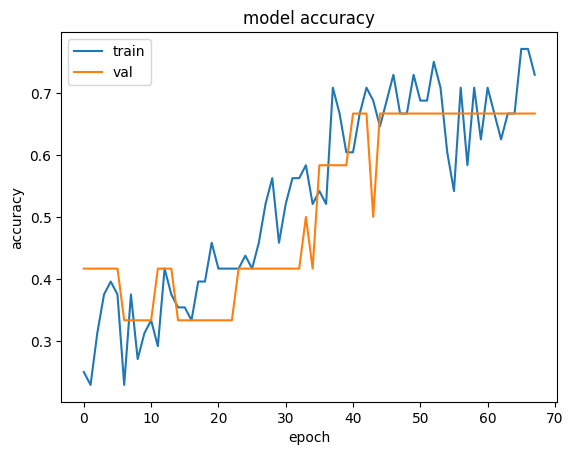

In [131]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

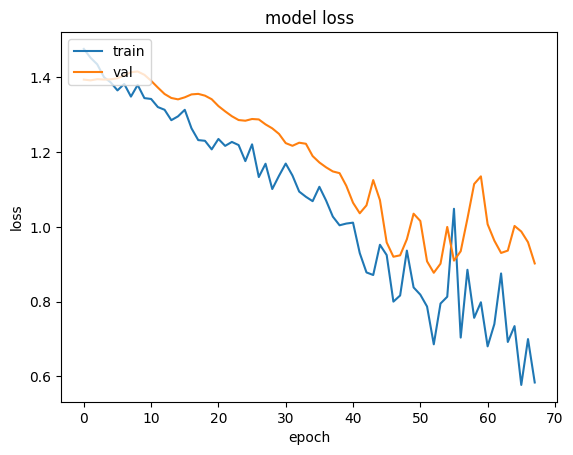

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [104]:
model.save('../../data/action_model/v%s_temp.h5' % MODEL_VERSION)